In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Plots
using DifferentialEquations: DP5, Tsit5, Vern7, Vern9, BS3
using Random
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

false

In [2]:
Random.seed!(1)

TaskLocalRNG()

In [3]:
ω₀ = 2π*5.0
η = -2π*300*1e-3
ω₀ += η
ωlo = ω₀

29.530970943744055

In [4]:
n_levels = 6
bs = FockBasis(n_levels-1)
a = destroy(bs)
ad = create(bs)
id = identityoperator(bs, bs);

In [5]:
H0 = ω₀*(ad*a + 0.5*id) + (η/12.0)*(a + ad)^4
H1 = 1.0im*(a - ad);

In [6]:
n_neurons = 8
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 2))
θ = Vector{Float64}(initial_params(ann));

In [7]:
coeffs(params, t) = let b = ann([t], params)
                        [b[1]*cos(ωlo*t) + b[2]*sin(ωlo*t)]
                    end
bcs(params) = -0.1*sum(ann([0.0], params).^2 + ann([4.0], params).^2)
                 
cost = CostFunction((x,y)->x'*y, bcs)

CostFunction(var"#1#2"(), bcs)

In [8]:
trans = UnitaryTransform([fockstate(bs, 0), fockstate(bs, 1)], 
                         [[1.0 -1.0im];[-1.0im 1.0]]/√2)
t0, t1 = 0.0, 4.0

(0.0, 4.0)

In [9]:
prob = QOCProblem((H0, [H1]), coeffs, trans, (t0, t1), cost);

In [10]:
sol = QuantumOptimalControl.optimize(prob, θ, ADAM(0.002), alg=DP5(), 
    abstol=1e-6, reltol=1e-6, n_iter=1500)

Progress: 100%|█████████████████████████████████████████| Time: 0:45:18
  cost:  0.9926418349493384


Solution{Float64}([-1.47328772284392, -0.3858179558080315, -1.8104904433717328, -0.3523067172274388, -1.7845237403717997, 0.3783237396093637, -1.2994680421894784, 0.5391138707754789, 0.732695660087639, 1.2386081123060242  …  -1.217246516385017, -1.6565483862290935, 1.346518660450723, 1.5058225547790438, 0.15906388343288777, -1.7769277948858895, -0.04002528288895939, 1.4056823886500955, 0.12065102508828122, -0.5046728610763329], [-0.029040628739515906, -0.026338832606968343, -0.024264288362012054, -0.022833051818742955, -0.02200178204706782, -0.021624305228939045, -0.02155892669033438, -0.021703697869651206, -0.021982176347922877, -0.02232475377540566  …  0.9929729916360737, 0.9929469937993065, 0.9929954837632755, 0.9929426085295112, 0.9930234522904509, 0.9929172117396137, 0.9930553330116798, 0.9928397408887234, 0.9930710224682379, 0.9926418349493384])

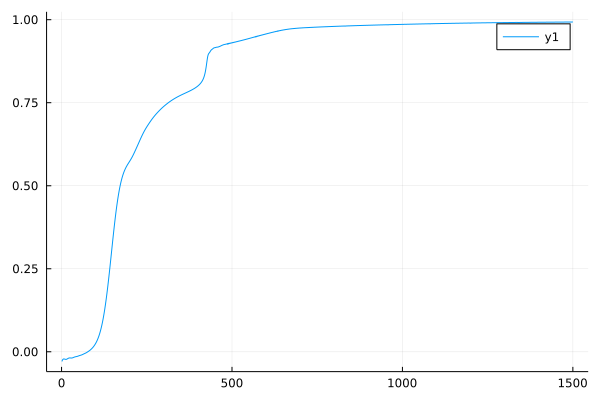

In [11]:
plot(sol.trace)

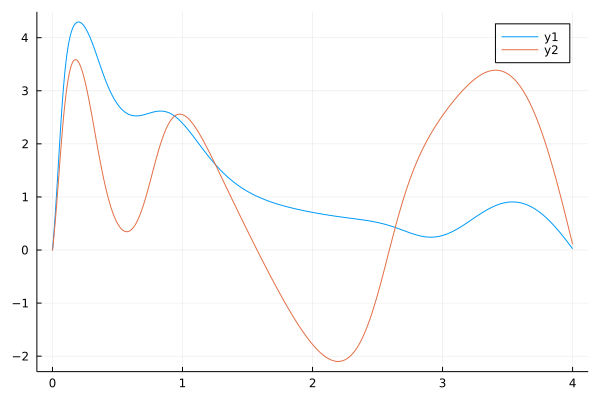

In [12]:
I(t) = ann([t], sol.params)[1]
Q(t) = ann([t], sol.params)[2]

ts = t0:0.001:t1
f = plot(ts, I.(ts))
plot!(f, ts, Q.(ts))